# Comp5318 Assignment2

ID:540919152

ID:540323234

**1. Setup: Import packages and libraries**

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Input
from scikeras.wrappers import KerasRegressor
import time

**2.Data loading, pre-processing, and exploration**

                 time    MT_001     MT_002     MT_003      MT_004     MT_005  \
0 2012-01-01 01:00:00  4.124365  22.759602  77.324066  138.211382  72.256098   
1 2012-01-01 02:00:00  4.758883  23.115220  77.324066  137.195122  70.121951   
2 2012-01-01 03:00:00  4.124365  22.937411  77.324066  136.686992  66.463415   
3 2012-01-01 04:00:00  4.758883  22.048364  77.324066  102.134146  50.304878   
4 2012-01-01 05:00:00  4.441624  21.870555  77.324066   81.808943  45.121951   

       MT_006    MT_007      MT_008     MT_009  ...      MT_091  MT_092  \
0  348.214286  8.620690  279.461279  72.989510  ...  128.252168     0.0   
1  339.285714  6.924816  276.094276  67.307692  ...  153.435624     0.0   
2  286.458333  6.642171  239.898990  63.811189  ...  142.428286     0.0   
3  191.964286  4.804975  200.336700  41.520979  ...  128.919280     0.0   
4  155.505952  3.533070  180.134680  45.891608  ...  119.579720     0.0   

     MT_093     MT_094    MT_095     MT_096      MT_097      MT_098 

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


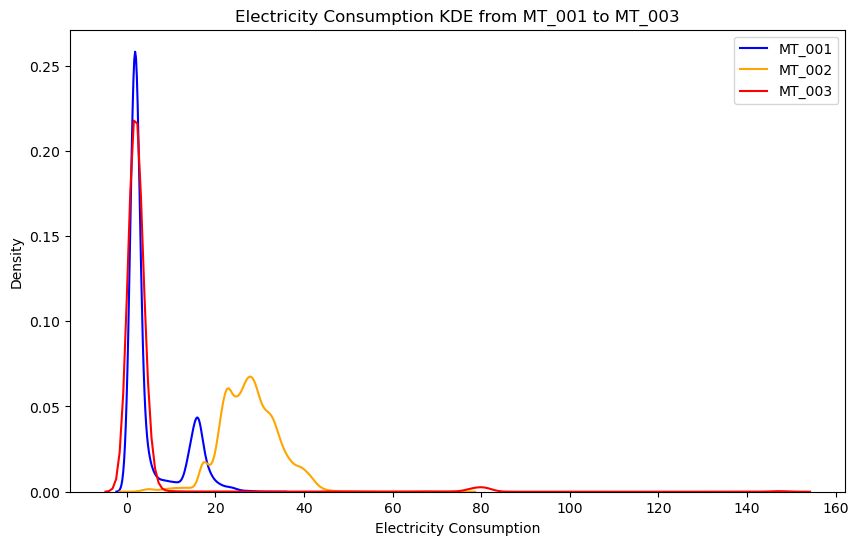

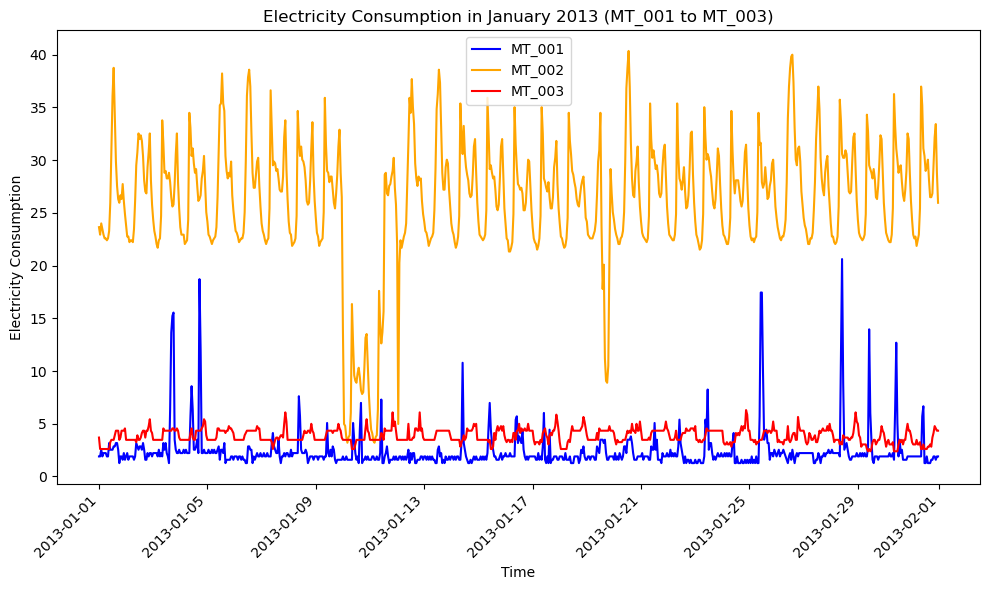

In [4]:
np.random.seed(5318)
tf.random.set_seed(5318)
random.seed(5318)

# Data loading
data = pd.read_csv('./Electricity_Dataset_Clean/LD2012_2014_clean.txt', sep=',', parse_dates=['time'])

# Exploration
print(data.head())
print(data.info())

# KDE
plt.figure(figsize=(10,6))
sns.kdeplot(data['MT_001'], label='MT_001', color='blue')
sns.kdeplot(data['MT_002'], label='MT_002', color='orange')
sns.kdeplot(data['MT_003'], label='MT_003', color='red')

plt.xlabel('Electricity Consumption')
plt.ylabel('Density')
plt.title('Electricity Consumption KDE from MT_001 to MT_003')
plt.legend()
plt.show()

# Select the users of MT001-MT003
target_columns = [f'MT_{i:03d}' for i in range(1, 4)]
features = data.drop(columns=['time'])

# Filter the data to get only January 2013
january_data = data[(data['time'] >= '2013-01-01') & (data['time'] < '2013-02-01')]

# Plot electricity consumption over time (first month of January 2013)
plt.figure(figsize=(10, 6))
plt.plot(january_data['time'], january_data['MT_001'], label='MT_001', color='blue')
plt.plot(january_data['time'], january_data['MT_002'], label='MT_002', color='orange')
plt.plot(january_data['time'], january_data['MT_003'], label='MT_003', color='red')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption in January 2013 (MT_001 to MT_003)')
plt.legend()

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


**3. Model selected: MLP, LSTM, GRU**

In [5]:
#MLP
def build_mlp_model(input_shape, neurons=64, optimizer='adam'):
    """
    Args:
        input_shape: The number of input features for the model.
        neurons: The number of neurons in the first Dense layer. Defaults to 64.
        optimizer: The optimizer to use for training the model. Defaults to 'adam'.

    Returns:
        keras.Sequential: Compiled MLP model.
    """
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

#LSTM
def build_lstm_model(input_shape, neurons=50, optimizer='adam'):
    """
    Args:
        input_shape: The number of input features for the model.
        neurons: The number of neurons in each LSTM layer. Defaults to 50.
        optimizer: The optimizer to use for training the model. Defaults to 'adam'.

    Returns:
        keras.Sequential: Compiled LSTM model.
    """    
    model = Sequential()
    model.add(Input(shape=(input_shape, 1)))    
    model.add(LSTM(neurons, return_sequences=True))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

#GLU
def build_gru_model(input_shape, neurons=50, optimizer='adam'):
    """
    Args:
        input_shape: The number of input features for the model.
        neurons: The number of neurons in each GRU layer. Defaults to 50.
        optimizer: The optimizer to use for training the model. Defaults to 'adam'.

    Returns:
        keras.Sequential: Compiled GRU model.
    """    
    model = Sequential()
    model.add(Input(shape=(input_shape, 1)))     
    model.add(GRU(neurons, return_sequences=True))
    model.add(GRU(neurons, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

**4. Hyperparameter tuning**

In [6]:
tscv = TimeSeriesSplit(n_splits=3)

def perform_random_search(build_fn, param_grid, X_train, y_train, input_shape, n_iter=3):
    model = KerasRegressor(model=build_fn, input_shape=input_shape, verbose=0)
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=n_iter, cv=2, random_state=5318, n_jobs=1)
    search_result = random_search.fit(X_train, y_train)
    print(f"Best parameters: {search_result.best_params_}")
    return search_result.best_estimator_

**5.Evaluation and Comparison**

Training and evaluating for MT_001
Best parameters: {'model__neurons': 32, 'epochs': 20}
MT_001 - MLP Model: MSE=1461.43, Training Time=15.18s, Prediction Time=0.80s
Best parameters: {'model__neurons': 32, 'epochs': 20}
MT_001 - LSTM Model: MSE=37.21, Training Time=328.75s, Prediction Time=10.44s
Best parameters: {'model__neurons': 64, 'epochs': 40}
MT_001 - GRU Model: MSE=41.98, Training Time=955.87s, Prediction Time=9.58s
Best parameters: {'model__neurons': 64, 'epochs': 40}
MT_001 - MLP Model: MSE=117.04, Training Time=50.49s, Prediction Time=0.74s
Best parameters: {'model__neurons': 64, 'epochs': 20}
MT_001 - LSTM Model: MSE=67.21, Training Time=771.38s, Prediction Time=10.44s
Best parameters: {'model__neurons': 64, 'epochs': 40}
MT_001 - GRU Model: MSE=67.42, Training Time=1431.27s, Prediction Time=7.80s
Best parameters: {'model__neurons': 64, 'epochs': 40}
MT_001 - MLP Model: MSE=36.94, Training Time=80.98s, Prediction Time=0.74s
Best parameters: {'model__neurons': 64, 'epochs': 

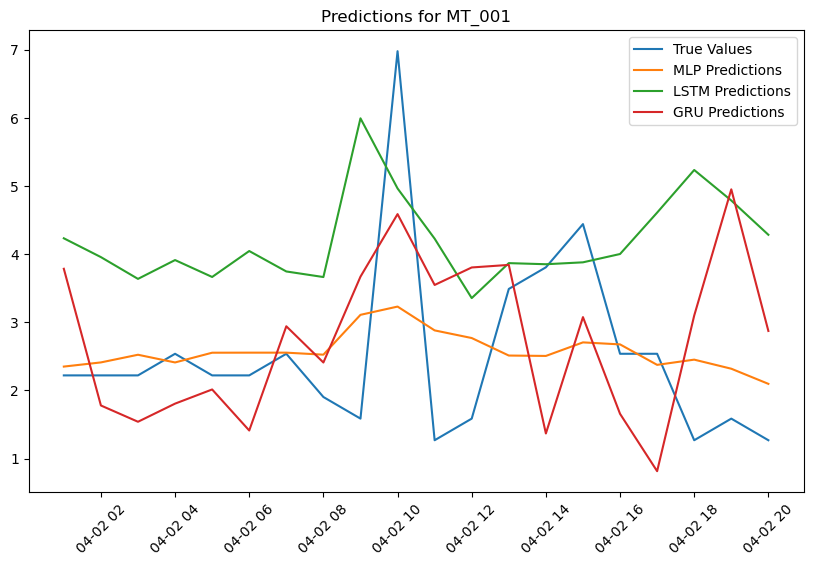

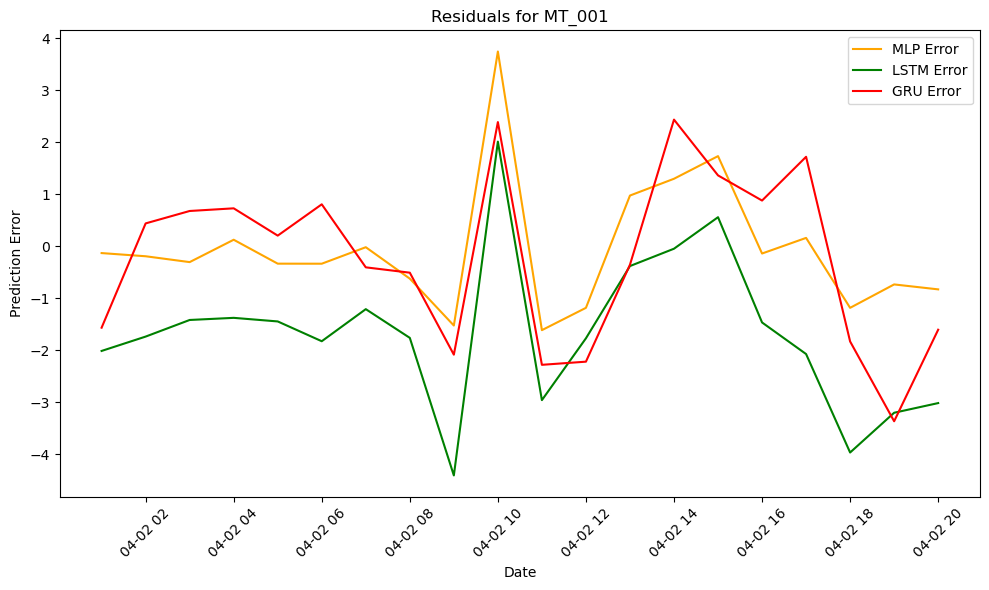

Training and evaluating for MT_002
Best parameters: {'model__neurons': 64, 'epochs': 20}
MT_002 - MLP Model: MSE=5004.53, Training Time=11.04s, Prediction Time=0.82s
Best parameters: {'model__neurons': 32, 'epochs': 20}
MT_002 - LSTM Model: MSE=50.12, Training Time=257.46s, Prediction Time=6.67s
Best parameters: {'model__neurons': 64, 'epochs': 40}
MT_002 - GRU Model: MSE=50.29, Training Time=698.87s, Prediction Time=7.64s
Best parameters: {'model__neurons': 64, 'epochs': 20}
MT_002 - MLP Model: MSE=65157.68, Training Time=16.69s, Prediction Time=0.75s
Best parameters: {'model__neurons': 32, 'epochs': 20}
MT_002 - LSTM Model: MSE=20.99, Training Time=440.96s, Prediction Time=6.96s
Best parameters: {'model__neurons': 64, 'epochs': 20}
MT_002 - GRU Model: MSE=18.59, Training Time=684.57s, Prediction Time=6.93s
Best parameters: {'model__neurons': 32, 'epochs': 20}
MT_002 - MLP Model: MSE=13.95, Training Time=27.40s, Prediction Time=0.64s
Best parameters: {'model__neurons': 32, 'epochs': 2

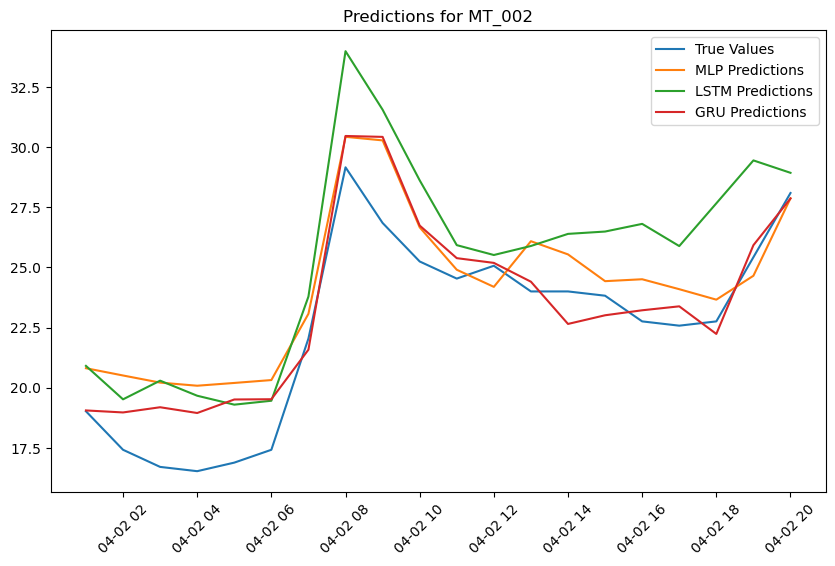

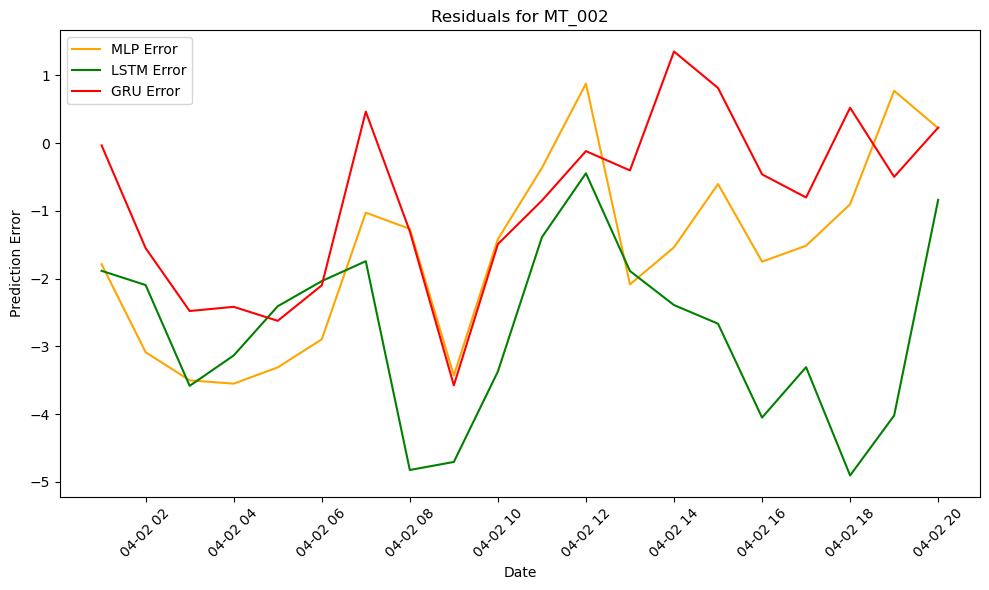

Training and evaluating for MT_003
Best parameters: {'model__neurons': 64, 'epochs': 20}
MT_003 - MLP Model: MSE=2433.30, Training Time=11.89s, Prediction Time=0.95s
Best parameters: {'model__neurons': 64, 'epochs': 20}
MT_003 - LSTM Model: MSE=173.75, Training Time=378.24s, Prediction Time=9.07s
Best parameters: {'model__neurons': 64, 'epochs': 40}
MT_003 - GRU Model: MSE=130.00, Training Time=847.98s, Prediction Time=8.26s
Best parameters: {'model__neurons': 32, 'epochs': 20}
MT_003 - MLP Model: MSE=4010.91, Training Time=25.28s, Prediction Time=0.79s
Best parameters: {'model__neurons': 64, 'epochs': 40}
MT_003 - LSTM Model: MSE=73.67, Training Time=1498.75s, Prediction Time=10.45s
Best parameters: {'model__neurons': 64, 'epochs': 20}
MT_003 - GRU Model: MSE=215.15, Training Time=797.86s, Prediction Time=10.47s
Best parameters: {'model__neurons': 64, 'epochs': 20}
MT_003 - MLP Model: MSE=0.19, Training Time=47.86s, Prediction Time=1.43s
Best parameters: {'model__neurons': 32, 'epochs

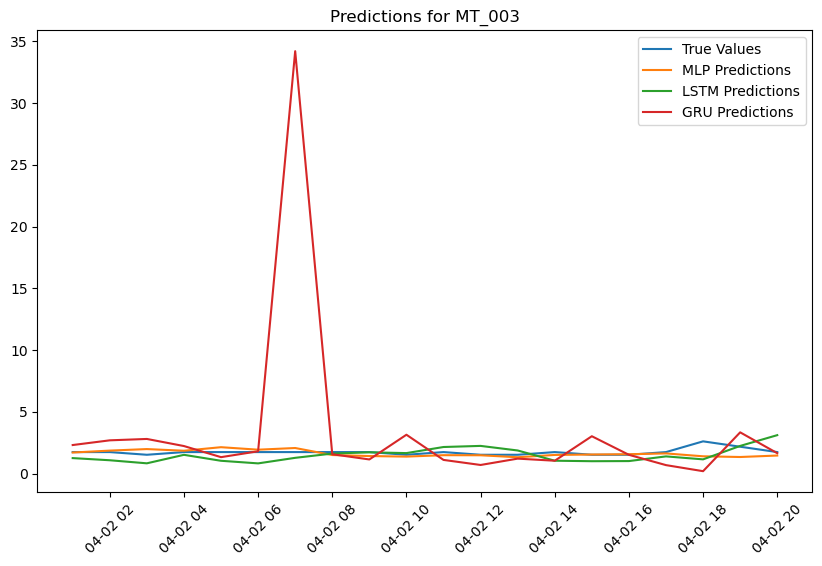

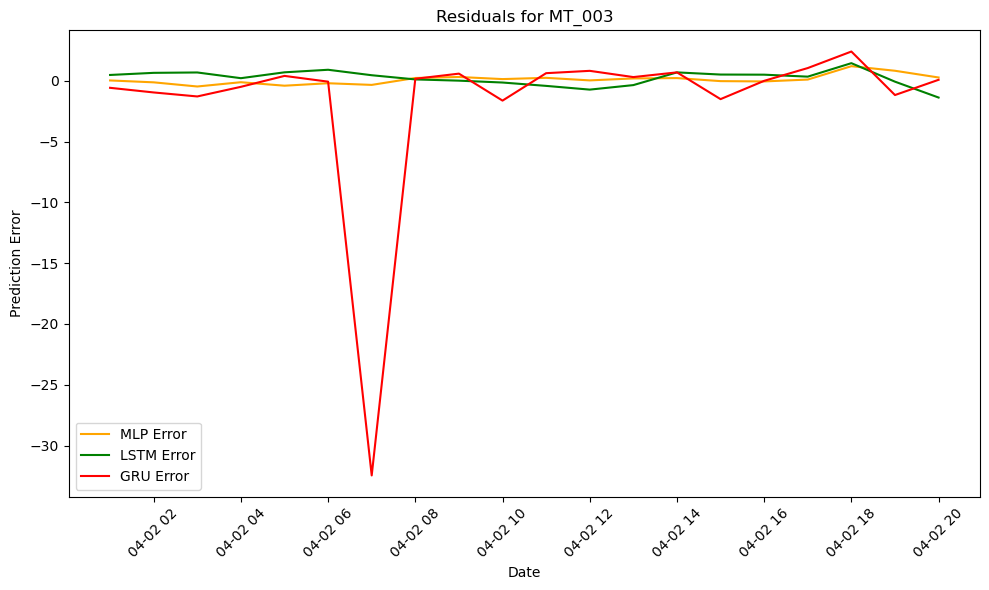

In [10]:
def train_and_evaluate(user):
    """
    Trains and evaluates three models (MLP, LSTM, GRU) for a specific user's electricity consumption data.
    
    This function finishes the tasks as follows:
    - Splits the data into training and test sets by TimeSeriesSplit.
    - Standardizes the data.
    - Performs hyperparameter tuning by RandomizedSearchCV.
    - Trains and evaluates each model and records the training time, prediction time, and MSE.
    - Visualizes the predictions from all three models compared to the true values.

    Args:
        user: The column name corresponding to the user's electricity consumption data.
    
    Returns:
        dict: A dictionary containing the results, including the timings and MSE for each model.
    """
    results = {}
    features_for_user = data.drop(columns=['time', user])
    target_for_user = data[user]

    # Standardize
    scaler = StandardScaler()
    input_shape = features_for_user.shape[1]

    timings = {}
    mse_values = {}
    print(f"Training and evaluating for {user}")

    # Hyperparameter grid
    param_grid = {
        'model__neurons': [32, 64],
        'epochs': [20, 40],
    }

    # Using TimeSeriesSplit
    for train_index, test_index in tscv.split(features_for_user):
        X_train, X_test = features_for_user.iloc[train_index], features_for_user.iloc[test_index]
        y_train, y_test = target_for_user.iloc[train_index], target_for_user.iloc[test_index]

        # Standardize the data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # MLP Model
        best_mlp = perform_random_search(build_mlp_model, param_grid, X_train_scaled, y_train, input_shape)
        start_time = time.time()
        best_mlp.fit(X_train_scaled, y_train)
        mlp_training_time = time.time() - start_time
        start_time = time.time()
        mlp_predictions = best_mlp.predict(X_test_scaled)
        mlp_prediction_time = time.time() - start_time
        mlp_mse = mean_squared_error(y_test, mlp_predictions)
        timings['MLP'] = (mlp_training_time, mlp_prediction_time)
        mse_values['MLP'] = mlp_mse
        print(f"{user} - MLP Model: MSE={mlp_mse:.2f}, Training Time={mlp_training_time:.2f}s, Prediction Time={mlp_prediction_time:.2f}s")

        # LSTM Model
        X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
        X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
        best_lstm = perform_random_search(build_lstm_model, param_grid, X_train_lstm, y_train, input_shape)
        start_time = time.time()
        best_lstm.fit(X_train_lstm, y_train)
        lstm_training_time = time.time() - start_time
        start_time = time.time()
        lstm_predictions = best_lstm.predict(X_test_lstm)
        lstm_prediction_time = time.time() - start_time
        lstm_mse = mean_squared_error(y_test, lstm_predictions)
        timings['LSTM'] = (lstm_training_time, lstm_prediction_time)
        mse_values['LSTM'] = lstm_mse
        print(f"{user} - LSTM Model: MSE={lstm_mse:.2f}, Training Time={lstm_training_time:.2f}s, Prediction Time={lstm_prediction_time:.2f}s")

        # GRU Model
        best_gru = perform_random_search(build_gru_model, param_grid, X_train_lstm, y_train, input_shape)
        start_time = time.time()
        best_gru.fit(X_train_lstm, y_train)
        gru_training_time = time.time() - start_time
        start_time = time.time()
        gru_predictions = best_gru.predict(X_test_lstm)
        gru_prediction_time = time.time() - start_time
        gru_mse = mean_squared_error(y_test, gru_predictions)
        timings['GRU'] = (gru_training_time, gru_prediction_time)
        mse_values['GRU'] = gru_mse
        print(f"{user} - GRU Model: MSE={gru_mse:.2f}, Training Time={gru_training_time:.2f}s, Prediction Time={gru_prediction_time:.2f}s")

    # Visualization using Time as x-axis
    plt.figure(figsize=(10,6))
    plt.plot(data.iloc[test_index]['time'].values[:20], y_test.values[:20], label="True Values")
    plt.plot(data.iloc[test_index]['time'].values[:20], mlp_predictions[:20], label="MLP Predictions")
    plt.plot(data.iloc[test_index]['time'].values[:20], lstm_predictions[:20], label="LSTM Predictions")
    plt.plot(data.iloc[test_index]['time'].values[:20], gru_predictions[:20], label="GRU Predictions")
    plt.legend()
    plt.title(f'Predictions for {user}')
    plt.xticks(rotation=45)
    plt.show()

    # Residuals (Errors) Visualization
    mlp_error = y_test.values[:20] - mlp_predictions[:20]
    lstm_error = y_test.values[:20] - lstm_predictions[:20]
    gru_error = y_test.values[:20] - gru_predictions[:20]

    plt.figure(figsize=(10,6))
    plt.plot(data.iloc[test_index]['time'].values[:20], mlp_error, label="MLP Error", color='orange')
    plt.plot(data.iloc[test_index]['time'].values[:20], lstm_error, label="LSTM Error", color='green')
    plt.plot(data.iloc[test_index]['time'].values[:20], gru_error, label="GRU Error", color='red')
    plt.legend()
    plt.title(f'Residuals for {user}')
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Prediction Error')
    plt.tight_layout()
    plt.show()

    results['user'] = user
    results['timings'] = timings
    results['mse'] = mse_values

    return results

# Sequential evaluation
def sequential_training():
    results = []
    for user in target_columns:
        result = train_and_evaluate(user)
        results.append(result)
    return results
all_results = sequential_training()

mlp_mse_list = []
lstm_mse_list = []
gru_mse_list = []
mlp_training_time_list = []
lstm_training_time_list = []
gru_training_time_list = []
mlp_prediction_time_list = []
lstm_prediction_time_list = []
gru_prediction_time_list = []

for result in all_results:
    user = result['user']
    mse = result['mse']
    timings = result['timings']
    mlp_mse_list.append(mse['MLP'])
    lstm_mse_list.append(mse['LSTM'])
    gru_mse_list.append(mse['GRU'])
    mlp_training_time_list.append(timings['MLP'][0])
    lstm_training_time_list.append(timings['LSTM'][0])
    gru_training_time_list.append(timings['GRU'][0])
    mlp_prediction_time_list.append(timings['MLP'][1])
    lstm_prediction_time_list.append(timings['LSTM'][1])
    gru_prediction_time_list.append(timings['GRU'][1])

avg_mlp_mse = np.mean(mlp_mse_list)
avg_lstm_mse = np.mean(lstm_mse_list)
avg_gru_mse = np.mean(gru_mse_list)
avg_mlp_training_time = np.mean(mlp_training_time_list)
avg_lstm_training_time = np.mean(lstm_training_time_list)
avg_gru_training_time = np.mean(gru_training_time_list)
avg_mlp_prediction_time = np.mean(mlp_prediction_time_list)
avg_lstm_prediction_time = np.mean(lstm_prediction_time_list)
avg_gru_prediction_time = np.mean(gru_prediction_time_list)

**6.Final Model**

In [11]:
print(f"Average MSE for MLP Model: {avg_mlp_mse:.2f}")
print(f"Average MSE for LSTM Model: {avg_lstm_mse:.2f}")
print(f"Average MSE for GRU Model: {avg_gru_mse:.2f}")
print(f"Average training time for MLP Model: {avg_mlp_training_time:.2f}")
print(f"Average training time for LSTM Model: {avg_lstm_training_time:.2f}")
print(f"Average training time for GRU Model: {avg_gru_training_time:.2f}")
print(f"Average prediction time for MLP Model: {avg_mlp_prediction_time:.2f}")
print(f"Average prediction time for LSTM Model: {avg_lstm_prediction_time:.2f}")
print(f"Average prediction time for GRU Model: {avg_gru_prediction_time:.2f}")

# Find the best model based on the lowest average MSE
best_model = min([
    ("MLP", avg_mlp_mse),
    ("LSTM", avg_lstm_mse),
    ("GRU", avg_gru_mse)
], key=lambda x: x[1])

# Print the best model
print(f"The best model is {best_model[0]} with an average MSE of {best_model[1]:.2f}")

Average MSE for MLP Model: 17.03
Average MSE for LSTM Model: 17.43
Average MSE for GRU Model: 24.46
Average training time for MLP Model: 52.08
Average training time for LSTM Model: 1001.45
Average training time for GRU Model: 1586.90
Average prediction time for MLP Model: 0.94
Average prediction time for LSTM Model: 8.89
Average prediction time for GRU Model: 7.49
The best model is MLP with an average MSE of 17.03
